In [2]:
import pandas as pd
import statsmodels.formula.api as smf # 数式で書ける便利なモジュール

df = pd.read_csv("d_data.csv")
print(df["inflation"].describe())
print((df["inflation"]/4).describe())
df["inflation"] = df['inflation_qoq'] = df['gdp_def'].pct_change(1) * 100
print(df["inflation"].describe())

count    179.000000
mean       0.441495
std        1.615078
min       -2.427638
25%       -0.819160
50%        0.157107
75%        1.605893
max        6.093906
Name: inflation, dtype: float64
count    179.000000
mean       0.110374
std        0.403769
min       -0.606909
25%       -0.204790
50%        0.039277
75%        0.401473
max        1.523477
Name: inflation, dtype: float64
count    182.000000
mean       0.128045
std        0.563714
min       -1.027077
25%       -0.201668
50%        0.000000
75%        0.407049
max        2.412281
Name: inflation, dtype: float64


In [3]:


# ==========================================
# 前処理: 差分とラグを作る
# ==========================================
# .diff() で変化量(Δ)を作る
df['d_cons'] = df['cons'].diff()
df['d_gdp'] = df['gdp'].diff()
df['d_t_total']    = df['t_total'].diff()

# ==========================================
# Step 1: 長期均衡式の推定 (Levels)
# ==========================================
# 式: 消費 ~ 所得 + 税
model_long = smf.ols('cons ~ gdp + t_total', data=df).fit()

# 結果表示
print("=== Step 1: Long Run ===")
print(model_long.summary())

# ★重要: 残差(ECM項)を計算して保存
# ecm = 実績 - 理論値(fittedvalues)
df['ecm'] = model_long.resid

# Step 2のために「1期前のズレ」を作る
df['ecm_lag1'] = df['ecm'].shift(1)

# ==========================================
# Step 2: 短期動学モデルの推定 (Differences)
# ==========================================
# 式: Δ消費 ~ Δ所得 + Δ税 + 前期のズレ(ECM)
# 欠損値(NaN)は自動で除外されるので気にしなくてOK
model_short = smf.ols('d_cons ~ d_gdp + d_t_total + ecm_lag1', data=df).fit()

# 結果表示
print("\n=== Step 2: Short Run (ECM) ===")
print(model_short.summary())

=== Step 1: Long Run ===
                            OLS Regression Results                            
Dep. Variable:                   cons   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.400e+04
Date:                Sat, 10 Jan 2026   Prob (F-statistic):          1.33e-195
Time:                        15:39:31   Log-Likelihood:                -1733.7
No. Observations:                 180   AIC:                             3473.
Df Residuals:                     177   BIC:                             3483.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9922.3588   160

In [4]:


# ==========================================
# 前処理: 差分とラグを作る
# ==========================================
# .diff() で変化量(Δ)を作る
df['d_cons'] = df['cons'].diff()
df['d_gdp'] = df['gdp'].diff()
df['d_t_total']    = df['t_total'].diff()
df['d_dispo_income']    = df['dispo_income'].diff()

# ==========================================
# Step 1: 長期均衡式の推定 (Levels)
# ==========================================
# 式: 消費 ~ 所得 + 税
model_long = smf.ols('cons ~ dispo_income', data=df).fit()

# 結果表示
print("=== Step 1: Long Run ===")
print(model_long.summary())

# ★重要: 残差(ECM項)を計算して保存
# ecm = 実績 - 理論値(fittedvalues)
df['ecm'] = model_long.resid

# Step 2のために「1期前のズレ」を作る
df['ecm_lag1'] = df['ecm'].shift(1)

# ==========================================
# Step 2: 短期動学モデルの推定 (Differences)
# ==========================================
# 式: Δ消費 ~ Δ所得 + Δ税 + 前期のズレ(ECM)
# 欠損値(NaN)は自動で除外されるので気にしなくてOK
model_short = smf.ols('d_cons ~ d_dispo_income + ecm_lag1', data=df).fit()

# 結果表示
print("\n=== Step 2: Short Run (ECM) ===")
print(model_short.summary())

=== Step 1: Long Run ===
                            OLS Regression Results                            
Dep. Variable:                   cons   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 2.369e+04
Date:                Sat, 10 Jan 2026   Prob (F-statistic):          2.79e-191
Time:                        15:39:31   Log-Likelihood:                -1749.2
No. Observations:                 180   AIC:                             3502.
Df Residuals:                     178   BIC:                             3509.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7669.7783

In [5]:
df[["date", "gdp", "t_total", "dispo_income", "cons"]].iloc[175:180]

,date,gdp,t_total,dispo_income,cons
175,2023-10-01,584165.1,68353.349889,515811.750111,304350.2
176,2024-01-01,581006.3,68939.550606,512066.749394,303295.8
177,2024-04-01,582394.9,69104.315532,513290.584468,303446.1
178,2024-07-01,586251.3,69561.898320,516689.401680,305069.6
179,2024-10-01,588234.4,69797.203898,518437.196102,304995.1


In [6]:
# Iの自己相関がひどい

df["lag_inv"] = df["inv"].shift(1)
df["lag_inv2"] = df["inv"].shift(2)

model_long = smf.ols('inv ~ lag_inv', data=df).fit()

# 結果表示
print("=== Step 1: Long Run ===")
print(model_long.summary())


model_long = smf.ols('inv ~ lag_inv + lag_inv2', data=df).fit()

# 結果表示
print("=== Step 1: Long Run ===")
print(model_long.summary())

=== Step 1: Long Run ===
                            OLS Regression Results                            
Dep. Variable:                    inv   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     9534.
Date:                Sat, 10 Jan 2026   Prob (F-statistic):          7.73e-158
Time:                        15:39:31   Log-Likelihood:                -1657.5
No. Observations:                 182   AIC:                             3319.
Df Residuals:                     180   BIC:                             3325.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2659.2014   111

In [7]:
import pandas as pd
import statsmodels.formula.api as smf

# ==========================================
# 前処理: 差分とラグを作る
# ==========================================
# inv: 投資, gdp: GDP, rate: 金利(実質or名目)
# ※ rate は % ではなく小数 (0.01) か 整数 (1.0) かスケールに注意
df['d_inv']  = df['inv'].diff()
df['d_gdp']  = df['gdp'].diff()
df['d_rate'] = df['long_rate'].diff() # 実質金利推奨

# ==========================================
# Step 1: 長期均衡式の推定 (Long Run)
# ==========================================
# 懸念: r と Y の相関が高くても、共和分があればOK
# 期待: gdpはプラス、rateはマイナス
model_long_inv = smf.ols('inv ~ gdp + long_rate', data=df).fit()

print("=== Step 1: Long Run (Investment) ===")
print(model_long_inv.summary())

# 残差(ECM項)を保存
df['ecm_inv'] = model_long_inv.resid
df['ecm_inv_lag1'] = df['ecm_inv'].shift(1)

# ==========================================
# Step 2: 短期動学モデル (Short Run)
# ==========================================
# 強い自己相関への対策:
# 消費関数と違い、投資は「慣性」がすごいので、
# 説明変数に「前期の投資の変化 (d_inv_lag1)」を入れるのがコツです。
df['d_inv_lag1'] = df['d_inv'].shift(1)

# 式: Δ投資 ~ ΔGDP + Δ金利 + ECM + 前期の勢い(慣性)
model_short_inv = smf.ols(
    'd_inv ~ d_gdp + d_rate + ecm_inv_lag1 + d_inv_lag1', 
    data=df
).fit()

print("\n=== Step 2: Short Run (Investment) ===")
print(model_short_inv.summary())

=== Step 1: Long Run (Investment) ===
                            OLS Regression Results                            
Dep. Variable:                    inv   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     21.21
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           7.42e-09
Time:                        15:39:31   Log-Likelihood:                -1618.2
No. Observations:                 156   AIC:                             3242.
Df Residuals:                     153   BIC:                             3252.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.

In [8]:
df.iloc[-5]

date                 2024-07-01
gdp_def                   109.0
gdp                    586251.3
cons                   305069.6
inv                    127838.6
gov                    149358.6
inflation              0.460829
long_rate             -1.679003
short_rate             0.177333
t_total             69561.89832
t_income           19610.119573
t_corp             16560.318153
t_cons             23131.553415
t_other             10259.90718
dispo_income       516689.40168
dispo_corp        569690.981847
inflation_qoq          0.460829
d_cons                   1623.5
d_gdp                    3856.4
d_t_total            457.582789
ecm                -6111.910126
ecm_lag1            -5738.88979
d_dispo_income      3398.817211
lag_inv                127030.4
lag_inv2               125871.6
d_inv                     808.2
d_rate                 1.010012
ecm_inv             5336.251663
ecm_inv_lag1        3439.146073
d_inv_lag1               1158.8
Name: 178, dtype: object

In [9]:
df.iloc[-4]

date                 2024-10-01
gdp_def                   109.9
gdp                    588234.4
cons                   304995.1
inv                    127737.0
gov                    149262.8
inflation              0.825688
long_rate             -1.975364
short_rate                0.227
t_total            69797.203898
t_income           19676.454314
t_corp             16616.336394
t_cons             23125.904538
t_other            10378.508652
dispo_income      518437.196102
dispo_corp        571618.063606
inflation_qoq          0.825688
d_cons                    -74.5
d_gdp                    1983.1
d_t_total            235.305577
ecm                -7213.092908
ecm_lag1           -6111.910126
d_dispo_income      1747.794423
lag_inv                127838.6
lag_inv2               127030.4
d_inv                    -101.6
d_rate                -0.296362
ecm_inv             4820.767661
ecm_inv_lag1        5336.251663
d_inv_lag1                808.2
Name: 179, dtype: object

1. 変数の定義


   * Y_t: t期のGDP
   * C_t: t期の民間消費
   * I_t: t期の民間投資
   * T_t: t期の税収
   * G_t: t期の政府支出
   * r_t: t期の長期金利
   * dY_t: GDPの変化量 (Y_t - Y_t-1)
   * dC_t, dI_t, dG_t, dT_t, dr_t: 各変数の変化量


  2. 誤差修正項（長期的な関係からのズレ）

  これらは、経済が長期的な均衡からどれだけズレているかを示す項で、t-1期の値から計算
  されます。


   * 消費のズレ: ecm_c_t-1 = C_t-1 - (7700 + 0.58 * (Y_t-1 - T_t-1))
   * 投資のズレ: ecm_i_t-1 = I_t-1 - (100000 + 0.03 * Y_t-1 - 1194 * r_t-1)

  3. 当期（t期）の同時方程式


  3つの内生変数 dY_t, dC_t, dI_t が、以下の3本の方程式で同時に決まります。

   1. 消費の変化 (dC_t):
      dC_t = 105 - 0.14 * ecm_c_t-1 + 0.49 * (dY_t - dT_t)


   2. 投資の変化 (dI_t):
      dI_t = -177 - 0.04 * ecm_i_t-1 + 0.29 * dI_t-1 - 48 * dr_t + 0.23 * dY_t

   3. GDPの定義式 (dY_t):
      dY_t = dC_t + dI_t + dG_t

  ---


  解説:
   * 式(1)は、消費の変化が「定数項(105)」「前期の長期的なズレの修正」「当期の可処分所
     得の変化（dY_t - dT_t）」で決まることを示しています。
   * 式(2)は、投資の変化が「定数項(-177)」「前期のズレの修正」「前期の投資の勢い(dI_t
     -1)」「当期の金利変化」「当期のGDP変化」で決まることを示しています。
   * 式(3)は、マクロ経済の基本的な恒等式（ISバランス）です。


  シミュレーションでは、毎期この連立方程式を解くことで、将来の経済の姿を予測してい
  ます。

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.dates as mdates

# 日本語フォント設定（環境に合わせて適宜変更してください。Colabの場合はjapanize_matplotlib推奨）
try:
    import japanize_matplotlib
except ImportError:
    pass # インストールされていなければ英語またはデフォルトフォントになります

# ==========================================
# 1. 計算エンジン (修正版)
# ==========================================
def simulate_next_step(current_df, delta_G=0, delta_T=0, delta_r=0):
    """
    データフレームの「最後の行」を現在地として、次の四半期の変化量を計算する
    """
    d = current_df
    
    # 最新行を取得
    last_row = d.iloc[-1]
    
    Y = last_row['gdp']
    C = last_row['cons']
    I = last_row['inv']
    T = last_row['t_total']
    r = last_row['long_rate']
    
    # 投資の勢い (ラグ2変数が必要なため、データが2行以上あるか確認)
    if len(d) >= 2:
        d_inv_prev = d['inv'].iloc[-1] - d['inv'].iloc[-2]
    else:
        d_inv_prev = 0 # 初期データしかない場合は勢い0と仮定

    # --- A. ギャップ計算 ---
    # ※定数項はモデルに合わせて調整済みと仮定
    C_target = 7700 + 0.58 * (Y - T)
    ecm_c = C - C_target

    I_target = 100000 + 0.03 * Y - 1194 * r
    ecm_i = I - I_target

    # --- B. 自律変動 ---
    # 消費: 定数 + ECM + 増税ショック
    C_auto = 105 - 0.14 * ecm_c - (0.49 * delta_T)

    # 投資: 定数 + ECM + 金利ショック + 慣性
    # ※ここで delta_r はポイント(例: +0.25)が入る想定
    I_auto = -177 - 0.04 * ecm_i - (48 * delta_r) + 0.29 * d_inv_prev

    # --- C. 乗数計算 ---
    # MPC=0.49, MPI=0.23 -> 乗数 = 1 / (1 - 0.72) = 3.57
    multiplier = 1.0 / 0.28
    
    total_shock = C_auto + I_auto + delta_G
    delta_Y = multiplier * total_shock

    # --- D. 確定 ---
    delta_C = C_auto + (0.49 * delta_Y)
    delta_I = I_auto + (0.23 * delta_Y)

    return {
        "d_gdp": delta_Y, "d_cons": delta_C, "d_inv": delta_I,
        "d_tax": delta_T, "d_rate": delta_r, "d_gov": delta_G
    }


In [11]:
# ==========================================
# 2. 初期データセットの作成 (頂いた最新データ)
# ==========================================
initial_data = {
    'date': [pd.Timestamp('2024-04-01'), pd.Timestamp('2024-07-01')], # ラグ計算用に2期分用意
    'gdp': [582394.9, 586251.3],
    'cons': [303446.1, 305069.6],
    'inv': [127030.4, 127838.6], # 7月の勢い計算用
    't_total': [69104.3, 69561.9],
    'long_rate': [-1.5, -1.679], # 適当な前期値補完
    'gov': [149000.0, 149358.6]  # ダミー政府支出
}
df_initial = pd.DataFrame(initial_data)

# ==========================================
# 3. シミュレーター (グラフ改良 & 借金実装版)
# ==========================================


# 初期データに「国債残高 (debt)」を追加
# 単位: 10億円 (GDPが約600兆円なので、借金は1200兆円=1,200,000くらいと仮定)
if 'debt' not in df_initial.columns:
    df_initial['debt'] = [1240000.0, 1250000.0] # ダミー初期値

class EconomyCockpitV2:
    def __init__(self, start_df):
        self.initial_df = start_df.copy()
        self.history_df = start_df.copy()
        self.turn = 0
        
        # UIパーツ
        self.out = widgets.Output()
        
        # 入力ボックス
        self.input_tax_pct = widgets.FloatText(value=0.0, step=1.0, description='税変化(%)', layout=widgets.Layout(width='140px'))
        self.input_rate_pt = widgets.FloatText(value=0.0, step=0.1, description='金利変化(pt)', layout=widgets.Layout(width='140px'))
        self.input_gov = widgets.FloatText(value=0.0, step=1000.0, description='財政出動(額)', layout=widgets.Layout(width='140px'))
        
        # ボタン
        self.btn_next = widgets.Button(description='実行', button_style='primary', icon='play')
        self.btn_next.on_click(self.on_next_click)
        
        self.btn_reset = widgets.Button(description='リセット', button_style='warning', icon='refresh')
        self.btn_reset.on_click(self.on_reset_click)

        # レイアウト
        self.ui = widgets.VBox([
            widgets.HTML("<h3>🏛️ 経済＆財政シミュレーター</h3>"),
            widgets.HBox([
                widgets.VBox([
                    widgets.Label("① 税収コントロール"),
                    self.input_tax_pct
                ]),
                widgets.VBox([
                    widgets.Label("② 金利コントロール"),
                    self.input_rate_pt
                ]),
                widgets.VBox([
                    widgets.Label("③ 財政出動 (G)"),
                    self.input_gov
                ]),
            ]),
            widgets.HBox([self.btn_next, self.btn_reset], layout=widgets.Layout(margin='20px 0 0 0'))
        ])
        
        self.update_plot()

    def run(self):
        display(self.ui, self.out)

    def on_next_click(self, b):
        # 1. 入力取得
        tax_pct = self.input_tax_pct.value
        rate_change = self.input_rate_pt.value
        gov_change_amount = self.input_gov.value # 今回の追加支出

        # 2. 前期データの取得
        last_row = self.history_df.iloc[-1]
        
        # 3. 変化額計算
        delta_T = last_row['t_total'] * (tax_pct / 100.0)
        
        # シミュレーション実行 (Gの変化は入力値をそのまま渡す)
        # ※ simulate_next_step は「Gの変化量」を受け取る仕様
        changes = simulate_next_step(
            self.history_df, 
            delta_G=gov_change_amount,
            delta_T=delta_T, 
            delta_r=rate_change
        )
        
        # 4. データ更新と行追加
        new_row = last_row.copy()
        new_row['date'] = last_row['date'] + pd.DateOffset(months=3)
        
        # フロー変数の更新
        new_row['gdp'] += changes['d_gdp']
        new_row['cons'] += changes['d_cons']
        new_row['inv'] += changes['d_inv']
        new_row['t_total'] += changes['d_tax']
        new_row['long_rate'] += changes['d_rate']
        
        # 政府支出(G)のストック更新
        # ※入力された gov_change_amount は「上乗せ分」なので、前期Gに足すか、
        #   それとも「ベースG + 追加G」にするか。ここでは「前期比」として足し込む
        new_row['gov'] += gov_change_amount 

        # ★国債残高(Debt)の更新★
        # 今期の赤字 = 政府支出(G) - 税収(T)
        # もし G > T なら赤字 → 借金が増える
        # もし T > G なら黒字 → 借金が減る
        primary_deficit = new_row['gov'] - new_row['t_total']
        new_row['debt'] += primary_deficit

        # DataFrameに追加
        self.history_df = pd.concat([self.history_df, pd.DataFrame([new_row])], ignore_index=True)
        self.turn += 1
        
        # 入力を0に戻す
        self.input_tax_pct.value = 0.0
        self.input_rate_pt.value = 0.0
        self.input_gov.value = 0.0
        
        self.update_plot()

    def on_reset_click(self, b):
        self.history_df = self.initial_df.copy()
        self.turn = 0
        self.update_plot()

    def update_plot(self):
        with self.out:
            clear_output(wait=True)
            cur = self.history_df.iloc[-1]
            
            # 数値サマリー
            print(f"【{cur['date'].strftime('%Y-%m')} (Turn {self.turn})】 GDP: {cur['gdp']:,.0f} | 国債: {cur['debt']:,.0f} (対GDP比: {cur['debt']/cur['gdp']:.1%})")
            print(f"  G(支出): {cur['gov']:,.0f} - T(税収): {cur['t_total']:,.0f} = 収支: {cur['t_total']-cur['gov']:+,.0f}")
            
            # グラフ描画
            fig, axes = plt.subplots(2, 2, figsize=(14, 9))
            dates = self.history_df['date']

            # [0,0] GDP
            ax = axes[0,0]
            ax.plot(dates, self.history_df['gdp'], 'o-', color='black', lw=2)
            ax.set_title('GDP (国内総生産)')
            ax.grid(True)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))

            # [0,1] 政策 (税と金利) - 2軸
            ax = axes[0,1]
            ax2 = ax.twinx()
            l1 = ax.plot(dates, self.history_df['t_total'], 's--', color='red', label='税収(左)')
            l2 = ax2.plot(dates, self.history_df['long_rate'], '^--', color='orange', label='金利(右)')
            ax.set_title('政策変数: 税収と金利')
            ax.legend(l1+l2, [l.get_label() for l in l1+l2])
            ax.grid(True)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))

            # [1,0] 民需 (消費と投資) - 2軸で重ねる！
            ax = axes[1,0]
            ax2 = ax.twinx() # 2軸化
            l1 = ax.plot(dates, self.history_df['cons'], 'o-', color='blue', label='消費(左)')
            l2 = ax2.plot(dates, self.history_df['inv'], 'd-', color='green', label='投資(右)')
            ax.set_title('内需のエンジン: 消費と投資')
            ax.legend(l1+l2, [l.get_label() for l in l1+l2])
            ax.grid(True)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))

            # [1,1] ★国債残高 (Debt)
            ax = axes[1,1]
            debt_ratio = self.history_df['debt'] / self.history_df['gdp'] * 100
            
            # 棒グラフで借金総額、折れ線で対GDP比を表示
            l1 = ax.bar(dates, self.history_df['debt'], width=60, color='gray', alpha=0.5, label='国債残高(左)')
            ax2 = ax.twinx()
            l2 = ax2.plot(dates, debt_ratio, 'r-', lw=2, label='対GDP比%(右)')
            
            ax.set_title('国の借金 (National Debt)')
            ax.legend([l1, l2[0]], ['残高', '対GDP比'], loc='upper left')
            ax.grid(True)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))

            plt.tight_layout()
            plt.show()

# 実行
app = EconomyCockpitV2(df_initial)
app.run()

Output()

In [12]:
# 記録されている全データを見る
display(app.history_df)

,date,gdp,cons,inv,t_total,long_rate,gov,debt
0,2024-04-01,582394.9,303446.1,127030.4,69104.3,-1.500,149000.0,1240000.0
1,2024-07-01,586251.3,305069.6,127838.6,69561.9,-1.679,149358.6,1250000.0


In [13]:
df.iloc[-6:]

,date,gdp_def,gdp,cons,inv,gov,inflation,long_rate,short_rate,t_total,...,ecm,ecm_lag1,d_dispo_income,lag_inv,lag_inv2,d_inv,d_rate,ecm_inv,ecm_inv_lag1,d_inv_lag1
177,2024-04-01,108.5,582394.9,303446.1,127030.4,149166.5,1.877934,-2.689014,0.077000,69104.315532,...,-5738.889790,-5170.289225,1223.835074,125871.6,128677.2,1158.8,-0.002542,3439.146073,2325.454789,-2805.6
178,2024-07-01,109.0,586251.3,305069.6,127838.6,149358.6,0.460829,-1.679003,0.177333,69561.898320,...,-6111.910126,-5738.889790,3398.817211,127030.4,125871.6,808.2,1.010012,5336.251663,3439.146073,1158.8
179,2024-10-01,109.9,588234.4,304995.1,127737.0,149262.8,0.825688,-1.975364,0.227000,69797.203898,...,-7213.092908,-6111.910126,1747.794423,127838.6,127030.4,-101.6,-0.296362,4820.767661,5336.251663,808.2
180,2025-01-01,110.4,590458.0,307197.5,127955.5,148875.2,0.454959,-2.297375,0.416000,NaN,...,NaN,-7213.092908,NaN,127737.0,127838.6,218.5,-0.322011,4587.476627,4820.767661,-101.6
181,2025-04-01,112.1,593596.9,307992.3,129453.5,149294.7,1.539855,-1.899747,0.477000,NaN,...,NaN,NaN,NaN,127955.5,127737.0,1498.0,0.397629,6465.059019,4587.476627,218.5
182,2025-07-01,112.7,590141.1,308605.9,127344.0,149198.9,0.535236,-1.820479,0.477333,NaN,...,NaN,NaN,NaN,129453.5,127955.5,-2109.5,0.079267,4554.897496,6465.059019,1498.0


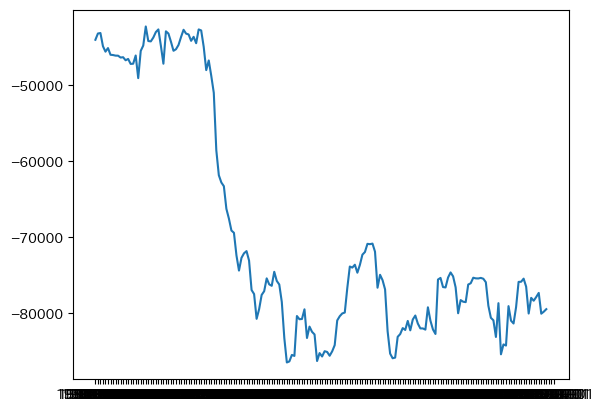

In [14]:
plt.plot(df["date"], df["t_total"]-df["gov"])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            183 non-null    object 
 1   gdp_def         183 non-null    float64
 2   gdp             183 non-null    float64
 3   cons            183 non-null    float64
 4   inv             183 non-null    float64
 5   gov             183 non-null    float64
 6   inflation       182 non-null    float64
 7   long_rate       156 non-null    float64
 8   short_rate      161 non-null    float64
 9   t_total         180 non-null    float64
 10  t_income        180 non-null    float64
 11  t_corp          180 non-null    float64
 12  t_cons          180 non-null    float64
 13  t_other         180 non-null    float64
 14  dispo_income    180 non-null    float64
 15  dispo_corp      180 non-null    float64
 16  inflation_qoq   182 non-null    float64
 17  d_cons          182 non-null    flo

In [16]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 1. データの準備
# GDPギャップの簡易計算: HPフィルタなどを使うのが正式ですが、
# ここでは「過去4期の平均GDP」をトレンドとみなして、そこからの乖離を見ます
df['gdp_trend'] = df['gdp'].rolling(window=8).mean()
df['gdp_gap'] = (df['gdp'] - df['gdp_trend']) / df['gdp_trend'] * 100

# インフレ率のラグ（粘着性）
df['inflation_lag1'] = df['inflation'].shift(1)

# 2. モデルの推定 (フィリップス曲線)
# インフレ率 ~ 定数 + GDPギャップ(需要要因) + 前期のインフレ(慣性)
# ※ 欠損値(NaN)を除去して計算
model_inflation = smf.ols('inflation ~ gdp_gap + inflation_lag1', data=df.dropna()).fit()

# 3. 結果の表示
print("=== インフレ率モデル (フィリップス曲線) ===")
print(model_inflation.summary())

=== インフレ率モデル (フィリップス曲線) ===
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     12.80
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           7.41e-06
Time:                        15:39:34   Log-Likelihood:                -109.24
No. Observations:                 152   AIC:                             224.5
Df Residuals:                     149   BIC:                             233.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       

In [17]:
df.columns

Index(['date', 'gdp_def', 'gdp', 'cons', 'inv', 'gov', 'inflation',
       'long_rate', 'short_rate', 't_total', 't_income', 't_corp', 't_cons',
       't_other', 'dispo_income', 'dispo_corp', 'inflation_qoq', 'd_cons',
       'd_gdp', 'd_t_total', 'ecm', 'ecm_lag1', 'd_dispo_income', 'lag_inv',
       'lag_inv2', 'd_inv', 'd_rate', 'ecm_inv', 'ecm_inv_lag1', 'd_inv_lag1',
       'gdp_trend', 'gdp_gap', 'inflation_lag1'],
      dtype='object')

In [18]:
df["inflation_lag1"] = df["inflation"].shift(1)
df["gdp_lag1"] = df["gdp"].shift(1)
df['gdp_gap_lag1'] = df['gdp_gap'].shift(1)
cycle, trend = sm.tsa.filters.hpfilter(df['gdp'], lamb=1600)
df['gdp_gap'] = cycle/trend
model = smf.ols('inflation ~ inflation_lag1 + gdp_gap+gdp_gap_lag1', data=df.dropna()).fit()

# 3. 結果の表示
print("=== インフレ率モデル (フィリップス曲線) ===")
print(model.summary())

=== インフレ率モデル (フィリップス曲線) ===
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     10.87
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           1.70e-06
Time:                        15:39:34   Log-Likelihood:                -106.16
No. Observations:                 152   AIC:                             220.3
Df Residuals:                     148   BIC:                             232.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       

/home/shouyanyonga/good_env/lib/python3.11/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [19]:
# 1. 移動平均（トレンド）の計算
# ゲームバランスを安定させるため、期間を「4」から「12（3年）」に少し伸ばすのを推奨しますが、4のままでも動きます。
trend = df["gdp"].rolling(window=12).mean() 

# 2. ギャップ率（%）の計算
# (実測値 - トレンド) / トレンド * 100
df['gap_percent'] = (df["gdp"] - trend) / trend * 100

# 3. ラグの作成
df['gap_percent_lag1'] = df['gap_percent'].shift(1)
df["inflation_lag1"] = df["inflation"].shift(1)

# 4. 回帰分析（変数をパーセント版に変更）
model_final = smf.ols('inflation ~ inflation_lag1 + gap_percent_lag1', data=df.dropna()).fit()

print("=== 最終版：インフレ率モデル ===")
print(model_final.summary())

=== 最終版：インフレ率モデル ===
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     19.10
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           4.14e-08
Time:                        15:39:34   Log-Likelihood:                -103.95
No. Observations:                 152   AIC:                             213.9
Df Residuals:                     149   BIC:                             223.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          

In [20]:
df.tail()

,date,gdp_def,gdp,cons,inv,gov,inflation,long_rate,short_rate,t_total,...,ecm_inv,ecm_inv_lag1,d_inv_lag1,gdp_trend,gdp_gap,inflation_lag1,gdp_lag1,gdp_gap_lag1,gap_percent,gap_percent_lag1
178,2024-07-01,109.0,586251.3,305069.6,127838.6,149358.6,0.460829,-1.679003,0.177333,69561.898320,...,5336.251663,3439.146073,1158.8,584614.3500,-0.000954,1.877934,582394.9,-0.277789,0.503100,0.028166
179,2024-10-01,109.9,588234.4,304995.1,127737.0,149262.8,0.825688,-1.975364,0.227000,69797.203898,...,4820.767661,5336.251663,808.2,585157.6125,0.000727,0.460829,586251.3,0.280005,0.724902,0.503100
180,2025-01-01,110.4,590458.0,307197.5,127955.5,148875.2,0.454959,-2.297375,0.416000,NaN,...,4587.476627,4820.767661,-101.6,585459.1625,0.002803,0.825688,588234.4,0.525805,0.923740,0.724902
181,2025-04-01,112.1,593596.9,307992.3,129453.5,149294.7,1.539855,-1.899747,0.477000,NaN,...,6465.059019,4587.476627,218.5,585959.7750,0.006421,0.454959,590458.0,0.853832,1.315439,0.923740
182,2025-07-01,112.7,590141.1,308605.9,127344.0,149198.9,0.535236,-1.820479,0.477333,NaN,...,4554.897496,6465.059019,1498.0,587031.0000,-0.001135,1.539855,593596.9,1.303353,0.601590,1.315439


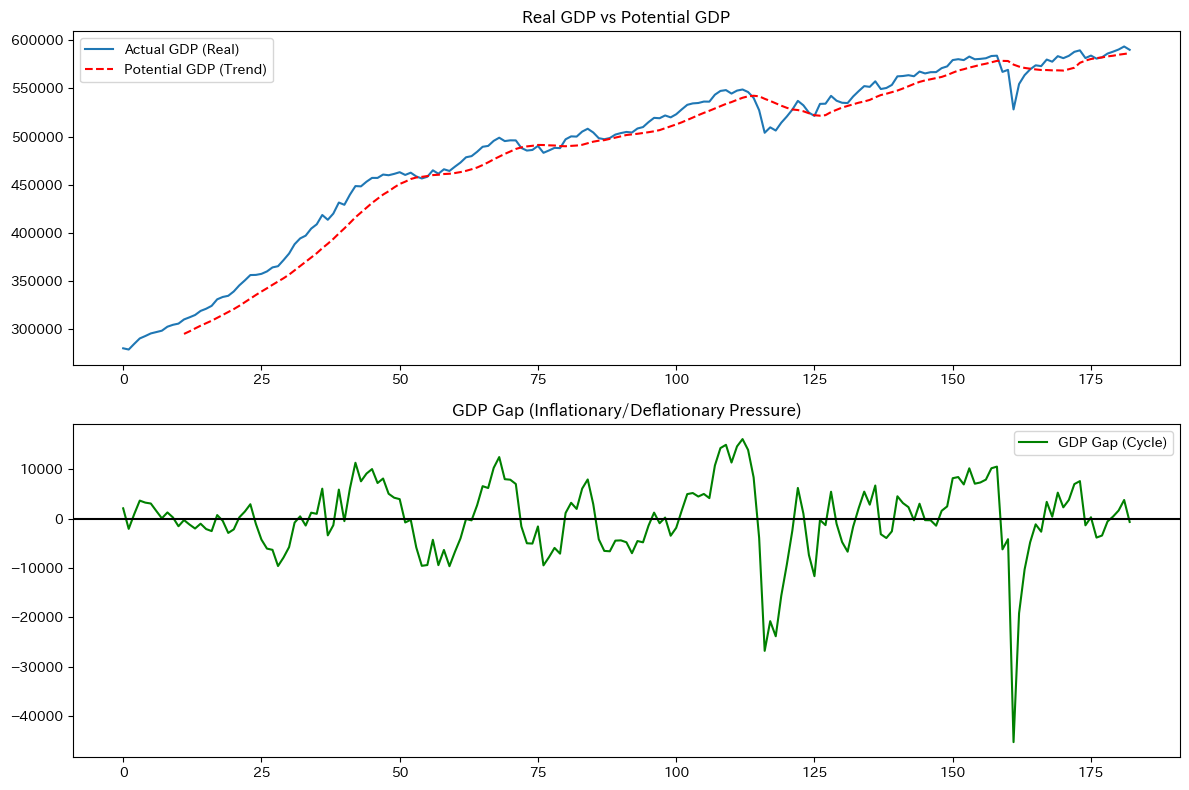

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# 上段：実質GDPとトレンド（潜在GDP）の比較
ax[0].plot(df.index, df['gdp'], label='Actual GDP (Real)')
ax[0].plot(df.index, trend, label='Potential GDP (Trend)', color='red', linestyle='--')
ax[0].set_title('Real GDP vs Potential GDP')
ax[0].legend()

# 下段：サイクル成分（GDPギャップ）
ax[1].plot(df.index, cycle, label='GDP Gap (Cycle)', color='green')
ax[1].axhline(0, color='black', linestyle='-') # 0のライン
ax[1].set_title('GDP Gap (Inflationary/Deflationary Pressure)')
ax[1].legend()

plt.tight_layout()
plt.show()

Text(0.5, 0, 'short_rate')

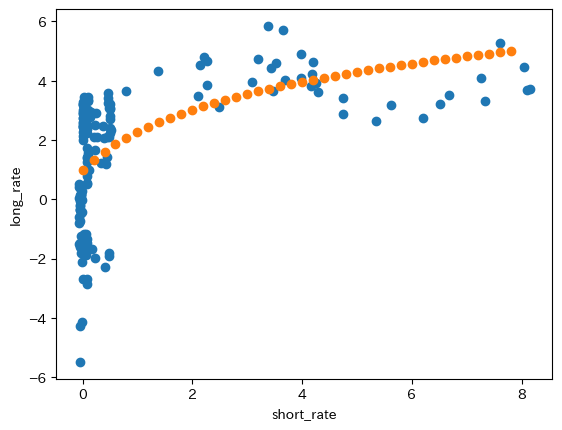

In [22]:
plt.scatter(df["short_rate"], df["long_rate"])
x = np.arange(0, 8, 0.2)
plt.scatter(x, 1.8452*np.log(x+1)+0.9876)
plt.ylabel("long_rate")
plt.xlabel("short_rate")

count    182.000000
mean       0.128045
std        0.563714
min       -1.027077
25%       -0.201668
50%        0.000000
75%        0.407049
max        2.412281
Name: inflation, dtype: float64

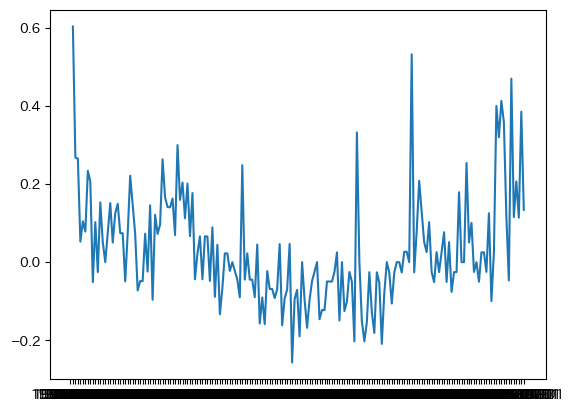

In [23]:
plt.plot(df["date"], df["inflation"]/4)
df["inflation"].describe()

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# 1. データの読み込みと下準備
df = pd.read_csv('d_data.csv')
df['date'] = pd.to_datetime(df['date'])

# シミュレーションに必要な主要変数を対数変換
# (gdp, cons, inv, dispo_income, gov)
cols = ['gdp', 'cons', 'inv', 'dispo_income', 'gov', 'gdp_def']
for col in cols:
    df[f'l_{col}'] = np.log(df[col])

# 階差（Δ: 変化量）とラグ（1期前）の作成
for col in cols:
    df[f'd_l_{col}'] = df[f'l_{col}'].diff()      # 今期の変化率
    df[f'lag_l_{col}'] = df[f'l_{col}'].shift(1)  # 前期のレベル

# 金利は％表記なのでそのまま（または100で割る）
df['r'] = df['long_rate'] / 100
df['d_r'] = df['r'].diff()

df_clean = df.dropna().copy()

# ---------------------------------------------------------
# 2. 消費関数の推定 (ECM + 2SLS)
# ---------------------------------------------------------

# 【長期均衡式】OLSで「あるべき消費水準」を出す
# log(cons) = const + theta * log(dispo_income)
X_c_lr = sm.add_constant(df_clean['l_dispo_income'])
res_c_lr = sm.OLS(df_clean['l_cons'], X_c_lr).fit()
# 誤差修正項(ECT)を保存
df_clean['ect_c'] = res_c_lr.resid
df_clean['lag_ect_c'] = df_clean['ect_c'].shift(1)

# 【短期ECM】2SLSで「今期の変化率」を出す
# d_log_cons = const + b1 * d_log_dispo_income + b2 * lag_ect_c
df_c = df_clean.dropna(subset=['lag_ect_c'])
# 内生変数: 今期の所得増減、 外生変数: 誤差修正項
endog = df_c[['d_l_dispo_income']]
exog = sm.add_constant(df_c[['lag_ect_c']])
# 操作変数: 今期の政府支出増減や前期の変数
instr = df_c[['d_l_gov', 'lag_l_dispo_income']]

model_c = IV2SLS(df_c['d_l_cons'], pd.concat([exog, endog], axis=1), 
                 pd.concat([exog, instr], axis=1)).fit()

# ---------------------------------------------------------
# 3. 投資関数の推定 (ECM + 2SLS)
# ---------------------------------------------------------

# 【長期均衡式】投資はGDPと金利に依存
X_i_lr = sm.add_constant(df_clean[['l_gdp', 'r']])
res_i_lr = sm.OLS(df_clean['l_inv'], X_i_lr).fit()
df_clean['ect_i'] = res_i_lr.resid
df_clean['lag_ect_i'] = df_clean['ect_i'].shift(1)

# 【短期ECM】
df_i = df_clean.dropna(subset=['lag_ect_i'])
endog_i = df_i[['d_l_gdp']]
exog_i = sm.add_constant(df_i[['d_r', 'lag_ect_i']])
instr_i = df_i[['d_l_gov', 'lag_l_gdp']]

model_i = IV2SLS(df_i['d_l_inv'], pd.concat([exog_i, endog_i], axis=1), 
                 pd.concat([exog_i, instr_i], axis=1)).fit()

# 結果の表示
print("--- Consumption Function (Short-run) ---")
print(model_c.summary())
print("\n--- Investment Function (Short-run) ---")
print(model_i.summary())

--- Consumption Function (Short-run) ---
                          IV2SLS Regression Results                           
Dep. Variable:               d_l_cons   R-squared:                       0.602
Model:                         IV2SLS   Adj. R-squared:                  0.597
Method:                     Two Stage   F-statistic:                     15.85
                        Least Squares   Prob (F-statistic):           5.79e-07
Date:                Sat, 10 Jan 2026                                         
Time:                        15:39:35                                         
No. Observations:                 151                                         
Df Residuals:                     148                                         
Df Model:                           2                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [25]:
# 物価データの準備
df_clean['l_p'] = np.log(df_clean['gdp_def'])
df_clean['d_l_p'] = df_clean['l_p'].diff()
df_clean['lag_d_l_p'] = df_clean['d_l_p'].shift(1)

df_p = df_clean.dropna(subset=['d_l_p', 'lag_d_l_p', 'd_l_gdp'])

# 2SLSで推定
# 物価に影響する「今期のGDP成長(d_l_y)」は内生的なので、Gの変化(d_l_gov)を操作変数にする
endog_p = df_p[['d_l_gdp']]
exog_p = sm.add_constant(df_p[['lag_d_l_p']])
instr_p = df_p[['d_l_gov', 'lag_l_gdp']] # 操作変数

model_p = IV2SLS(df_p['d_l_p'], pd.concat([exog_p, endog_p], axis=1), 
                 pd.concat([exog_p, instr_p], axis=1)).fit()

print(model_p.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                  d_l_p   R-squared:                       0.129
Model:                         IV2SLS   Adj. R-squared:                  0.117
Method:                     Two Stage   F-statistic:                     11.45
                        Least Squares   Prob (F-statistic):           2.40e-05
Date:                Sat, 10 Jan 2026                                         
Time:                        15:39:35                                         
No. Observations:                 150                                         
Df Residuals:                     147                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.623      0.5

In [26]:
def simulate_one_step(G_current, tax_rate, r_current, prev_data, coeffs):
    """
    1期分（3ヶ月分）の経済変化を計算する
    """
    # 1. 前期のデータから ECT (誤差修正項) を計算しておく
    ect_c = prev_data['l_cons'] - (coeffs['c_lr_const'] + coeffs['c_lr_y'] * prev_data['l_dispo_income'])
    ect_i = prev_data['l_inv'] - (coeffs['i_lr_const'] + coeffs['i_lr_y'] * prev_data['l_gdp'] + coeffs['i_lr_r'] * prev_data['r'])
    
    # 2. 収束計算（Y, C, I を同時に解く）
    Y_guess = prev_data['gdp']  # 最初の仮定
    for i in range(100):  # 最大100回ループ
        # 税収 T と 可処分所得 Yd の計算
        T = tax_rate * Y_guess
        Yd = Y_guess - T
        d_l_Yd = np.log(Yd) - prev_data['l_dispo_income']
        
        # 消費の変化率とレベルの計算
        d_l_C = coeffs['c_const'] + coeffs['c_ect'] * ect_c + coeffs['c_yd'] * d_l_Yd
        C_new = np.exp(prev_data['l_cons'] + d_l_C)
        
        # 投資の変化率とレベルの計算
        d_l_Y = np.log(Y_guess) - prev_data['l_gdp']
        d_l_I = coeffs['i_const'] + coeffs['i_ect'] * ect_i + coeffs['i_y'] * d_l_Y + coeffs['i_r'] * (r_current - prev_data['r'])
        I_new = np.exp(prev_data['l_inv'] + d_l_I)
        
        # 新しいGDPを計算 (Y = C + I + G)
        Y_new = C_new + I_new + G_current
        
        # 収束判定（変化が極小になったら終了）
        if abs(Y_new - Y_guess) < 0.001:
            break
        Y_guess = Y_new # 更新して次のループへ

    # 3. 決まった Y_new を使って物価 P を更新
    d_l_P = coeffs['p_const'] + coeffs['p_lag'] * prev_data['d_l_p'] + coeffs['p_y'] * d_l_Y
    P_new = np.exp(prev_data['l_p'] + d_l_P)

    return {"gdp": Y_new, "cons": C_new, "inv": I_new, "p": P_new}


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display, clear_output

# ============================
# 初期データ
# ============================
initial_data = {
    'date': [pd.Timestamp('2024-04-01'), pd.Timestamp('2024-07-01')],
    'Y': [582394.9, 586251.3],
    'C': [303446.1, 305069.6],
    'I': [127030.4, 127838.6],
    'G': [149000.0, 149000.0],
    'P': [100.0, 100.2],
    'r': [-1.5, -1.679],
    'tau': [0.1186, 0.1186],   # 実効税率
}
df_initial = pd.DataFrame(initial_data)

# ============================
# 構造方程式
# ============================

def consumption_ecm(C_prev, Yd, Yd_prev):
    lnC_star_prev = -0.0956 + 0.9687 * np.log(Yd_prev)
    ect = np.log(C_prev) - lnC_star_prev
    dlnC = (-0.0001
            + 0.9401 * (np.log(Yd) - np.log(Yd_prev))
            - 0.1619 * ect)
    return np.exp(np.log(C_prev) + dlnC)

def investment_ecm(I_prev, Y, Y_prev, r, r_prev):
    lnI_star_prev = 11.4687 + 0.0165 * np.log(Y_prev) - 1.3035 * r_prev
    ect = np.log(I_prev) - lnI_star_prev
    dlnI = (-0.0005
            + 0.7773 * (np.log(Y) - np.log(Y_prev))
            - 0.0798 * (r - r_prev)
            - 0.0386 * ect)
    return np.exp(np.log(I_prev) + dlnI)

def price_update(P_prev, Y, Y_prev, inflation_prev):
    dlnP = (0.0004
            + 0.3714 * inflation_prev
            + 0.0012 * (np.log(Y) - np.log(Y_prev)))
    return P_prev * np.exp(dlnP), dlnP

# ============================
# アプリ本体
# ============================

class EconomyCockpitECM:
    def __init__(self, df):
        self.initial_df = df.copy()
        self.df = df.copy()
        self.turn = 0

        self.out = widgets.Output()

        self.input_tau = widgets.FloatSlider(
            value=0.12, min=0.05, max=0.3, step=0.005, description='税率 τ'
        )
        self.input_r = widgets.FloatSlider(
            value=0.0, min=-1.0, max=1.0, step=0.05, description='金利変化'
        )
        self.input_G = widgets.FloatSlider(
            value=0.0, min=-20000, max=20000, step=500, description='G変更'
        )

        self.btn_next = widgets.Button(description='実行', button_style='primary')
        self.btn_reset = widgets.Button(description='リセット', button_style='warning')

        self.btn_next.on_click(self.step)
        self.btn_reset.on_click(self.reset)

        self.ui = widgets.VBox([
            widgets.HTML("<h3>🏛️ マクロ経済シミュレーター（ECM）</h3>"),
            self.input_tau,
            self.input_r,
            self.input_G,
            widgets.HBox([self.btn_next, self.btn_reset])
        ])

        self.plot()

    def run(self):
        display(self.ui, self.out)

    def step(self, b):
        prev = self.df.iloc[-1]
        Y = prev['Y']
        Y_prev = self.df.iloc[-2]['Y']

        tau = self.input_tau.value
        r = prev['r'] + self.input_r.value
        G = prev['G'] + self.input_G.value

        # ガウス＝ザイデル
        for _ in range(20):
            T = tau * Y
            Yd = Y - T
            Yd_prev = Y_prev - prev['tau'] * Y_prev

            C = consumption_ecm(prev['C'], Yd, Yd_prev)
            I = investment_ecm(prev['I'], Y, Y_prev, r, prev['r'])

            Y_new = C + I + G
            if abs(Y_new - Y) < 1e-3:
                break
            Y = Y_new

        P, infl = price_update(prev['P'], Y, Y_prev,
                                np.log(prev['P'] / self.df.iloc[-2]['P']))

        new_row = {
            'date': prev['date'] + pd.DateOffset(months=3),
            'Y': Y,
            'C': C,
            'I': I,
            'G': G,
            'P': P,
            'r': r,
            'tau': tau
        }

        self.df = pd.concat([self.df, pd.DataFrame([new_row])], ignore_index=True)
        self.turn += 1
        self.plot()

    def reset(self, b):
        self.df = self.initial_df.copy()
        self.turn = 0
        self.plot()

    def plot(self):
        with self.out:
            clear_output(wait=True)
            fig, axes = plt.subplots(2, 2, figsize=(14, 9))
            d = self.df['date']

            axes[0,0].plot(d, self.df['Y'], 'k-o')
            axes[0,0].set_title('GDP')

            ax = axes[0,1]
            ax2 = ax.twinx()
            ax.plot(d, self.df['tau'] * self.df['Y'], 'r--', label='税収')
            ax2.plot(d, self.df['r'], 'orange', label='金利')
            ax.set_title('政策変数')
            ax.legend(loc='upper left')
            ax.grid(True)

            axes[1,0].plot(d, self.df['C'], label='C')
            axes[1,0].plot(d, self.df['I'], label='I')
            axes[1,0].plot(d, self.df['G'], label='G')
            axes[1,0].set_title('内需エンジン')
            axes[1,0].legend()
            axes[1,0].grid(True)

            axes[1,1].plot(d, self.df['P'], 'm-o')
            axes[1,1].set_title('物価水準')
            axes[1,1].grid(True)

            for ax in axes.flatten():
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))

            plt.tight_layout()
            plt.show()

# 実行
app = EconomyCockpitECM(df_initial)
app.run()


Output()

In [28]:
import numpy as np

def calculate_support_rate(growth, inflation, unemployment, prev_support):
    # 成長ボーナス (成長率1% = +10ポイント)
    bonus = growth * 10.0 
    # インフレペナルティ (目標0.5%からの乖離1% = -50ポイント)
    p_penalty = abs(inflation - 0.005) * 50.0
    # 失業ペナルティ (2.5%を超えた分1%につき = -100ポイント)
    u_penalty = max(0, unemployment - 0.025) * 100.0
    
    new_support = prev_support + bonus - p_penalty - u_penalty
    
    # np.clipを使って0〜100の間に収める
    return np.clip(new_support, 0, 100)

# テスト実行
current_support = calculate_support_rate(
    growth=0.02,      # 成長率 2%
    inflation=0.005,   # インフレ 0.5% (目標通り)
    unemployment=0.03, # 失業率 3.0% (目標2.5%より高い)
    prev_support=50.0  # 前回の支持率 50%
)

print(f"計算後の支持率: {current_support:.1f}%")

計算後の支持率: 49.7%


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display, clear_output

# ============================
# 初期データ
# ============================
initial_data = {
    'date': [pd.Timestamp('2024-04-01'), pd.Timestamp('2024-07-01')],
    'Y': [582394.9, 586251.3],
    'C': [303446.1, 305069.6],
    'I': [127030.4, 127838.6],
    'G': [149000.0, 149000.0],
    'P': [100.0, 100.2],
    'r': [-1.5, -1.679],
    'tau': [0.1186, 0.1186],
    'unemployment': [0.026, 0.025], # 初期失業率 2.5%
    'support': [50.0, 52.0]        # 初期支持率 50%
}
df_initial = pd.DataFrame(initial_data)

# ============================
# 構造方程式・評価ロジック
# ============================

def consumption_ecm(C_prev, Yd, Yd_prev):
    lnC_star_prev = -0.0956 + 0.9687 * np.log(Yd_prev)
    ect = np.log(C_prev) - lnC_star_prev
    dlnC = (-0.0001 + 0.9401 * (np.log(Yd) - np.log(Yd_prev)) - 0.1619 * ect)
    return np.exp(np.log(C_prev) + dlnC)

def investment_ecm(I_prev, Y, Y_prev, r, r_prev):
    lnI_star_prev = 11.4687 + 0.0165 * np.log(Y_prev) - 1.3035 * r_prev
    ect = np.log(I_prev) - lnI_star_prev
    dlnI = (-0.0005 + 0.7773 * (np.log(Y) - np.log(Y_prev)) - 0.0798 * (r - r_prev) - 0.0386 * ect)
    return np.exp(np.log(I_prev) + dlnI)

def price_update(P_prev, Y, Y_prev, inflation_prev):
    dlnP = (0.0004 + 0.3714 * inflation_prev + 0.0012 * (np.log(Y) - np.log(Y_prev)))
    return P_prev * np.exp(dlnP), dlnP

def calculate_support_rate(growth, inflation, unemployment, prev_support):
    # 1. 成長ボーナス (年率2%成長程度でプラス)
    bonus = (growth - 0.005) * 20.0 
    # 2. インフレペナルティ (目標四半期0.5%からの乖離)
    p_penalty = abs(inflation - 0.005) * 60.0
    # 3. 失業ペナルティ (2.5%を超えると不満)
    u_penalty = max(0, unemployment - 0.025) * 150.0
    
    new_support = prev_support + bonus - p_penalty - u_penalty
    return np.clip(new_support, 0, 100)

# ============================
# アプリ本体
# ============================

class EconomyCockpitECM:
    def __init__(self, df):
        self.initial_df = df.copy()
        self.df = df.copy()
        self.turn = 0
        self.out = widgets.Output()

        # UIコンポーネント
        self.input_tau = widgets.FloatSlider(value=0.12, min=-0.25, max=0.25, step=0.005, description='税率 τ')
        self.input_r = widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.01, description='金利変化')
        self.input_G = widgets.FloatSlider(value=0.0, min=-10000, max=10000, step=500, description='G増減')

        self.btn_next = widgets.Button(description='実行（次期へ）', button_style='primary')
        self.btn_reset = widgets.Button(description='リセット', button_style='warning')

        self.btn_next.on_click(self.step)
        self.btn_reset.on_click(self.reset)

        self.ui = widgets.VBox([
            widgets.HTML("<h3>🏛️ 財務省になろう：マクロ経済シミュレーター</h3>"),
            widgets.HBox([self.input_tau, self.input_r, self.input_G]),
            widgets.HBox([self.btn_next, self.btn_reset])
        ])
        self.plot()

    def run(self):
        display(self.ui, self.out)

    def step(self, b):
        prev = self.df.iloc[-1]
        Y_prev = self.df.iloc[-2]['Y']
        Y = prev['Y']
        
        tau = self.input_tau.value
        r = prev['r'] + self.input_r.value
        G = prev['G'] + self.input_G.value

        # ガウス＝ザイデル収束計算
        for _ in range(30):
            T = tau * Y
            Yd = Y - T
            Yd_prev = Y_prev - prev['tau'] * Y_prev
            C = consumption_ecm(prev['C'], Yd, Yd_prev)
            I = investment_ecm(prev['I'], Y, Y_prev, r, prev['r'])
            Y_new = C + I + G
            if abs(Y_new - Y) < 1e-3: break
            Y = Y_new

        # 物価更新
        inflation_prev = np.log(prev['P'] / self.df.iloc[-2]['P'])
        P, infl = price_update(prev['P'], Y, Y_prev, inflation_prev)

        # --- 評価軸の計算 ---
        # 1. 成長率
        growth_rate = np.log(Y / Y_prev)
        # 2. 失業率 (オークンの法則: 成長率が高いと失業が減る)
        potential_growth = 0.002 
        unemployment = prev['unemployment'] - 0.15 * (growth_rate - potential_growth)
        unemployment = max(0.01, unemployment) # 下限1%
        # 3. 支持率
        support = calculate_support_rate(growth_rate, infl, unemployment, prev['support'])

        new_row = {
            'date': prev['date'] + pd.DateOffset(months=3),
            'Y': Y, 'C': C, 'I': I, 'G': G, 'P': P, 'r': r, 'tau': tau,
            'unemployment': unemployment, 'support': support
        }

        self.df = pd.concat([self.df, pd.DataFrame([new_row])], ignore_index=True)
        self.turn += 1
        self.plot()

    def reset(self, b):
        self.df = self.initial_df.copy()
        self.turn = 0
        self.plot()

    def plot(self):
        with self.out:
            clear_output(wait=True)
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            d = self.df['date']

            # GDP
            axes[0,0].plot(d, self.df['Y'], 'k-o')
            axes[0,0].set_title('実質GDP (最大化目標)')
            axes[0,0].grid(True)

            # 内閣支持率
            axes[0,1].plot(d, self.df['support'], 'b-s', linewidth=2)
            axes[0,1].axhline(30, color='red', linestyle='--', label='危険水準')
            axes[0,1].set_title('内閣支持率 (%)')
            axes[0,1].set_ylim(0, 100)
            axes[0,1].legend()
            axes[0,1].grid(True)

            # 失業率
            axes[0,2].plot(d, self.df['unemployment'] * 100, 'g-^')
            axes[0,2].set_title('失業率 (雇用安定目標: %)')
            axes[0,2].grid(True)

            # 内需コンポーネント
            axes[1,0].plot(d, self.df['C'], label='消費 C')
            axes[1,0].plot(d, self.df['I'], label='投資 I')
            axes[1,0].plot(d, self.df['G'], label='政府 G')
            axes[1,0].set_title('需要内訳')
            axes[1,0].legend()
            axes[1,0].grid(True)

            # 政策変数 (税収と金利)
            ax_p = axes[1,1]
            ax_p2 = ax_p.twinx()
            ax_p.bar(d, self.df['tau'] * self.df['Y'], color='gray', alpha=0.3, label='税収', width=40)
            ax_p2.plot(d, self.df['r'], 'orange', label='金利 r', linewidth=2)
            ax_p.set_title('財政・金融政策')
            ax_p.legend(loc='upper left'); ax_p2.legend(loc='upper right')

            # 物価
            axes[1,2].plot(d, self.df['P'], 'm-o')
            axes[1,2].set_title('物価水準 (安定目標)')
            axes[1,2].grid(True)

            for ax in axes.flatten():
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
            
            plt.tight_layout()
            plt.show()

# 実行
app = EconomyCockpitECM(df_initial)
app.run()

Output()

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# 1. データの読み込みと下準備
df = pd.read_csv('d_data.csv')
df['date'] = pd.to_datetime(df['date'])

# シミュレーションに必要な主要変数を対数変換
# (gdp, cons, inv, dispo_income, gov)
cols = ['gdp', 'cons', 'inv', 'dispo_income', 'gov', 'gdp_def']
for col in cols:
    df[f'l_{col}'] = np.log(df[col])

# 階差（Δ: 変化量）とラグ（1期前）の作成
for col in cols:
    df[f'd_l_{col}'] = df[f'l_{col}'].diff()      # 今期の変化率
    df[f'lag_l_{col}'] = df[f'l_{col}'].shift(1)  # 前期のレベル

# 金利は％表記なのでそのまま（または100で割る）
df['r'] = df['long_rate'] / 100
df['d_r'] = df['r'].diff()

df_clean = df.dropna()

# ---------------------------------------------------------
# 2. 消費関数の推定 (ECM + 2SLS)
# ---------------------------------------------------------

# 【長期均衡式】OLSで「あるべき消費水準」を出す
# log(cons) = const + theta * log(dispo_income)
X_c_lr = sm.add_constant(df_clean['l_dispo_income'])
res_c_lr = sm.OLS(df_clean['l_cons'], X_c_lr).fit()
# 誤差修正項(ECT)を保存
df_clean['ect_c'] = res_c_lr.resid
df_clean['lag_ect_c'] = df_clean['ect_c'].shift(1)

# 【短期ECM】2SLSで「今期の変化率」を出す
# d_log_cons = const + b1 * d_log_dispo_income + b2 * lag_ect_c
df_c = df_clean.dropna(subset=['lag_ect_c'])
# 内生変数: 今期の所得増減、 外生変数: 誤差修正項
endog = df_c[['d_l_dispo_income']]
exog = sm.add_constant(df_c[['lag_ect_c']])
# 操作変数: 今期の政府支出増減や前期の変数
instr = df_c[['d_l_gov', 'lag_l_dispo_income']]

model_c = IV2SLS(df_c['d_l_cons'], pd.concat([exog, endog], axis=1), 
                 pd.concat([exog, instr], axis=1)).fit()

# ---------------------------------------------------------
# 3. 投資関数の推定 (ECM + 2SLS)
# ---------------------------------------------------------

# 【長期均衡式】投資はGDPと金利に依存
X_i_lr = sm.add_constant(df_clean[['l_gdp', 'r']])
res_i_lr = sm.OLS(df_clean['l_inv'], X_i_lr).fit()
df_clean['ect_i'] = res_i_lr.resid
df_clean['lag_ect_i'] = df_clean['ect_i'].shift(1)

# 【短期ECM】
df_i = df_clean.dropna(subset=['lag_ect_i'])
endog_i = df_i[['d_l_gdp']]
exog_i = sm.add_constant(df_i[['d_r', 'lag_ect_i']])
instr_i = df_i[['d_l_gov', 'lag_l_gdp']]

model_i = IV2SLS(df_i['d_l_inv'], pd.concat([exog_i, endog_i], axis=1), 
                 pd.concat([exog_i, instr_i], axis=1)).fit()

# 結果の表示
print("--- Consumption Function (long-run) ---")
print(res_c_lr.summary())
print("--- Consumption Function (Short-run) ---")
print(model_c.summary())
print("\n--- Investment Function (long-run) ---")
print(res_i_lr.summary())
print("\n--- Investment Function (Short-run) ---")
print(model_i.summary())

--- Consumption Function (long-run) ---
                            OLS Regression Results                            
Dep. Variable:                 l_cons   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     8093.
Date:                Sat, 10 Jan 2026   Prob (F-statistic):          2.08e-132
Time:                        19:08:06   Log-Likelihood:                 424.36
No. Observations:                 152   AIC:                            -844.7
Df Residuals:                     150   BIC:                            -838.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
cons

/tmp/ipykernel_15760/832009377.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ect_c'] = res_c_lr.resid
/tmp/ipykernel_15760/832009377.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['lag_ect_c'] = df_clean['ect_c'].shift(1)
/tmp/ipykernel_15760/832009377.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [53]:
""" import statsmodels.api as sm

# 8期（2年）の移動平均で「潜在GDP」を定義
# center=Trueにすることで、その時期を中心とした平均をとります
df_clean['l_gdp_potential'] = df_clean['l_gdp'].rolling(window=8, center=True).mean()

# データの端（最初と最後）は平均が取れず欠損するので、線形補完するか削除します
df_clean = df_clean.interpolate(limit_direction='both') 

# GDPギャップ = 実際 - 潜在
df_clean['gdp_gap'] = df_clean['l_gdp'] - df_clean['l_gdp_potential']

# 再推定用のデータセット
df_p = df_clean.dropna(subset=['d_l_gdp_def', 'lag_l_gdp_def', 'lag_gdp_gap'])

y_p = df_p['d_l_gdp_def']
X_p = sm.add_constant(df_p[['lag_l_gdp_def', 'lag_gdp_gap']])

model_p_new = sm.OLS(y_p, X_p).fit()
print(model_p_new.summary()) """
print("hello")

hello


In [43]:
"""import statsmodels.api as sm

# 8期（2年）の移動平均で「潜在GDP」を定義
# center=Trueにすることで、その時期を中心とした平均をとります
df_clean['l_gdp_potential'] = df_clean['l_gdp'].rolling(window=8, center=True).mean()

# データの端（最初と最後）は平均が取れず欠損するので、線形補完するか削除します
df_clean = df_clean.interpolate(limit_direction='both') 

# GDPギャップ = 実際 - 潜在
df_clean['gdp_gap'] = df_clean['l_gdp'] - df_clean['l_gdp_potential']
df_clean['d_lag_l_gdp_def'] = df_clean['d_l_gdp_def'].diff(1)
# 再推定用のデータセット
df_p = df_clean.dropna(subset=['d_l_gdp_def', 'd_lag_l_gdp_def', 'lag_gdp_gap'])

y_p = df_p['d_l_gdp_def']
X_p = sm.add_constant(df_p[['d_lag_l_gdp_def', 'lag_gdp_gap']])

model_p_new = sm.OLS(y_p, X_p).fit()
print(model_p_new.summary())"""
print("hello")

                            OLS Regression Results                            
Dep. Variable:            d_l_gdp_def   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     42.21
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           3.13e-15
Time:                        21:10:25   Log-Likelihood:                 609.13
No. Observations:                 151   AIC:                            -1212.
Df Residuals:                     148   BIC:                            -1203.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.000     

In [52]:
"""
df_clean['l_p'] = np.log(df_clean['gdp_def'])

df_clean['d_l_p'] = df_clean['l_p'].diff()      # 今期のインフレ率

df_clean['lag_d_l_p'] = df_clean['d_l_p'].shift(1) # 前期のインフレ率



# 2. 推定用のデータセット作成

# 必要な変数が揃っている行だけを抽出

df_p = df_clean.dropna(subset=['d_l_p', 'lag_d_l_p', 'd_l_gdp'])



# 3. 2SLSによる推定

# 被説明変数: 今期のインフレ率 (d_l_p)

# 内生変数: 今期のGDP成長率 (d_l_gdp) -> 物価と同時に決まるため

# 外生変数: 前期のインフレ率 (lag_d_l_p)

# 操作変数: 今期の政府支出の変化率 (d_l_gov) などを利用

endog_p = df_p[['d_l_gdp']]

exog_p = sm.add_constant(df_p[['lag_d_l_p']])

instr_p = df_p[['d_l_gov', 'lag_l_gdp']] # 操作変数



model_p = IV2SLS(df_p['d_l_p'], 

                 pd.concat([exog_p, endog_p], axis=1), 

                 pd.concat([exog_p, instr_p], axis=1)).fit()



print(model_p.summary())
"""
print("hello")

hello


In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- 準備：インフレ率の変化（d_lag_l_gdp_def）をあらかじめ作成 ---
df_clean['d_lag_l_gdp_def'] = df_clean['d_l_gdp_def'].shift(1)

"""
# --- 案1：線形トレンドによる潜在GDP ---
# 時間軸（0, 1, 2...）を作成し、実質GDP（l_gdp）を回帰して直線を引く
df_clean['time_idx'] = np.arange(len(df_clean))
res_trend = sm.OLS(df_clean['l_gdp'], sm.add_constant(df_clean['time_idx'])).fit()
df_clean['l_potential_1'] = res_trend.predict() # これが線形トレンド（案1）
df_clean['gap_1'] = df_clean['l_gdp'] - df_clean['l_potential_1']
"""


# --- 案2：指数平滑化（適応的期待）による潜在GDP ---
# alpha=0.1 で実際のGDPを追いかける（過去データの保持が不要な手法）
alpha = 0.1
l_pot_2 = [df_clean['l_gdp'].iloc[0]] # 初期値
for i in range(1, len(df_clean)):
    # 潜在 = (1-α)*前の潜在 + α*今のGDP
    val = (1 - alpha) * l_pot_2[-1] + alpha * df_clean['l_gdp'].iloc[i]
    l_pot_2.append(val)
df_clean['l_potential_2'] = l_pot_2
df_clean['gap_2'] = df_clean['l_gdp'] - df_clean['l_potential_2']

# --- 推定と比較 ---
def estimate_inflation_model(gap_col):
    df_sub = df_clean.dropna(subset=['d_l_gdp_def', 'd_lag_l_gdp_def', gap_col])
    y = df_sub['d_l_gdp_def']
    # 前期のギャップを説明変数にする
    X = sm.add_constant(pd.concat([df_sub['d_lag_l_gdp_def'], df_sub[gap_col].shift(1)], axis=1))
    model = sm.OLS(y, X, missing='drop').fit()
    return model

model_1 = estimate_inflation_model('gap_1')
model_2 = estimate_inflation_model('gap_2')

#print("--- 案1: 線形トレンド ---")
#print(f"AIC: {model_1.aic:.2f}, R-squared: {model_1.rsquared:.32f}")
#print(model_1.params)

print("\n--- 案2: 指数平滑化 (alpha=0.1) ---")
print(f"AIC: {model_2.aic:.2f}, R-squared: {model_2.rsquared:.2f}")
print(model_2.params)


--- 案2: 指数平滑化 (alpha=0.1) ---
AIC: -1167.84, R-squared: 0.19
const             -0.000975
d_lag_l_gdp_def    0.307883
gap_2              0.050145
dtype: float64


In [112]:

import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- 準備：インフレ率の変化（d_lag_l_gdp_def）をあらかじめ作成 ---
df_clean['d_lag_l_gdp_def'] = df_clean['d_l_gdp_def'].shift(1)

# --- 案2：指数平滑化（適応的期待）による潜在GDP ---
# alpha=0.1 で実際のGDPを追いかける（過去データの保持が不要な手法）
alpha = 0.1
l_pot_2 = [df_clean['l_gdp'].iloc[0]] # 初期値
for i in range(1, len(df_clean)):
    # 潜在 = (1-α)*前の潜在 + α*今のGDP
    val = (1 - alpha) * l_pot_2[-1] + alpha * df_clean['l_gdp'].iloc[i]
    l_pot_2.append(val)
df_clean['l_potential_2'] = l_pot_2
df_clean['gap_2'] = df_clean['l_gdp'] - df_clean['l_potential_2']

# --- 推定と比較 ---
def estimate_inflation_model(gap_col):
    df_sub = df_clean.dropna(subset=['d_l_gdp_def', 'd_lag_l_gdp_def', gap_col])
    y = df_sub['d_l_gdp_def']
    # 前期のギャップを説明変数にする
    X = sm.add_constant(pd.concat([df_sub['d_lag_l_gdp_def'], df_sub[gap_col].shift(1)], axis=1))
    model = sm.OLS(y, X, missing='drop').fit()
    return model

model_2 = estimate_inflation_model('gap_2')

print("\n--- 案2: 指数平滑化 (alpha=0.1) ---")
print(f"AIC: {model_2.aic:.2f}, R-squared: {model_2.rsquared:.2f}")
print(model_2.params)


alpha = 0.13
l_pot_2 = [df_clean['l_gdp'].iloc[0]] # 初期値
for i in range(1, len(df_clean)):
    # 潜在 = (1-α)*前の潜在 + α*今のGDP
    val = (1 - alpha) * l_pot_2[-1] + alpha * df_clean['l_gdp'].iloc[i]
    l_pot_2.append(val)
df_clean['l_potential_2'] = l_pot_2
df_clean['gap_2'] = df_clean['l_gdp'] - df_clean['l_potential_2']

# --- 推定と比較 ---
def estimate_inflation_model(gap_col):
    df_sub = df_clean.dropna(subset=['d_l_gdp_def', 'd_lag_l_gdp_def', gap_col])
    y = df_sub['d_l_gdp_def']
    # 前期のギャップを説明変数にする
    X = sm.add_constant(pd.concat([df_sub['d_lag_l_gdp_def'], df_sub[gap_col].shift(1)], axis=1))
    model = sm.OLS(y, X, missing='drop').fit()
    return model

model_2 = estimate_inflation_model('gap_2')

print("\n--- 案2: 指数平滑化 (alpha=0.13) ---")
print(f"AIC: {model_2.aic:.2f}, R-squared: {model_2.rsquared:.2f}")
print(model_2.params)


alpha = 0.15
l_pot_2 = [df_clean['l_gdp'].iloc[0]] # 初期値
for i in range(1, len(df_clean)):
    # 潜在 = (1-α)*前の潜在 + α*今のGDP
    val = (1 - alpha) * l_pot_2[-1] + alpha * df_clean['l_gdp'].iloc[i]
    l_pot_2.append(val)
df_clean['l_potential_2'] = l_pot_2
df_clean['gap_2'] = df_clean['l_gdp'] - df_clean['l_potential_2']

# --- 推定と比較 ---
def estimate_inflation_model(gap_col):
    df_sub = df_clean.dropna(subset=['d_l_gdp_def', 'd_lag_l_gdp_def', gap_col])
    y = df_sub['d_l_gdp_def']
    # 前期のギャップを説明変数にする
    X = sm.add_constant(pd.concat([df_sub['d_lag_l_gdp_def'], df_sub[gap_col].shift(1)], axis=1))
    model = sm.OLS(y, X, missing='drop').fit()
    return model

model_2 = estimate_inflation_model('gap_2')

print("\n--- 案2: 指数平滑化 (alpha=0.15) ---")
print(f"AIC: {model_2.aic:.2f}, R-squared: {model_2.rsquared:.2f}")
print(model_2.params)


alpha = 0.14
l_pot_2 = [df_clean['l_gdp'].iloc[0]] # 初期値
for i in range(1, len(df_clean)):
    # 潜在 = (1-α)*前の潜在 + α*今のGDP
    val = (1 - alpha) * l_pot_2[-1] + alpha * df_clean['l_gdp'].iloc[i]
    l_pot_2.append(val)
df_clean['l_potential_2'] = l_pot_2
df_clean['gap_2'] = df_clean['l_gdp'] - df_clean['l_potential_2']

# --- 推定と比較 ---
def estimate_inflation_model(gap_col):
    df_sub = df_clean.dropna(subset=['d_l_gdp_def', 'd_lag_l_gdp_def', gap_col])
    y = df_sub['d_l_gdp_def']
    # 前期のギャップを説明変数にする
    X = sm.add_constant(pd.concat([df_sub['d_lag_l_gdp_def'], df_sub[gap_col].shift(1)], axis=1))
    model = sm.OLS(y, X, missing='drop').fit()
    return model

model_2 = estimate_inflation_model('gap_2')

print("\n--- 案2: 指数平滑化 (alpha=0.14) ---")
print(f"AIC: {model_2.aic:.2f}, R-squared: {model_2.rsquared:.2f}")
print(model_2.params)


print("hello")


--- 案2: 指数平滑化 (alpha=0.1) ---
AIC: -1167.84, R-squared: 0.19
const             -0.000975
d_lag_l_gdp_def    0.307883
gap_2              0.050145
dtype: float64

--- 案2: 指数平滑化 (alpha=0.13) ---
AIC: -1169.14, R-squared: 0.20
const             -0.000850
d_lag_l_gdp_def    0.306058
gap_2              0.060993
dtype: float64

--- 案2: 指数平滑化 (alpha=0.15) ---
AIC: -1169.33, R-squared: 0.20
const             -0.000761
d_lag_l_gdp_def    0.309033
gap_2              0.066700
dtype: float64

--- 案2: 指数平滑化 (alpha=0.14) ---
AIC: -1169.28, R-squared: 0.20
const             -0.000805
d_lag_l_gdp_def    0.307267
gap_2              0.063972
dtype: float64
hello


In [111]:
pi_star = 0.0  # デフレOK世界

df_b["infl_gap"] = df_b["infl"] - pi_star

smf.ols(
    "infl_gap ~ infl_gap.shift(1) + dgdp.shift(1)",
    data=df_b
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               infl_gap   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     21.31
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           5.05e-09
Time:                        11:40:55   Log-Likelihood:                -124.33
No. Observations:                 181   AIC:                             254.7
Df Residuals:                     178   BIC:                             264.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0348      0.039      0.888      0.376      -0.043       0.112
infl_gap.shift(1)     0.4040      0.064      6.264      0.000       0.277       0.531
dgdp.shift(1)         0.0699      0.031      2.286      0.023       0.010       0.130
==============================================================================
Omnibus:                       49.824   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.161
Skew:                           1.197   Prob(JB):                     1.33e-26
Kurtosis:                       6.173   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


lnC = -0.0436 + 0.9647 * log(Y-T)
ect = log(C_prev) - lnC_star_prev
dlnC = -0.0001 + 0.8896 * (log(Y - T) - log(Y_prev - T_prev)) - 0.1589 * ect
C = exp(log(C_prev) + dlnC)

lnI_star_prev = 10.6456 + 0.0788 * log(Y_prev) - 1.1401 * r_prev
ect = log(I_prev) - lnI_star_prev
dlnI = -0.0008 + 0.9362 * (log(Y) - log(Y_prev)) - 0.1318 * (r - r_prev) - 0.0401 * ect
I = exp(log(I_prev) + dlnI)

dlnP = 0.0005 + 0.4829 * dlnP_prev + 0.0709 * gdp_gap_prev
gdp_gap_prev = log(Y_prev) - log(Y_potential_prev)
log(Y_potential_initial) = (過去8期の log(Y) の平均値)
P = exp(log(P_prev) + dlnP)

In [35]:
pd.read_csv("d_data.csv").columns

Index(['date', 'gdp_def', 'gdp', 'cons', 'inv', 'gov', 'inflation',
       'long_rate', 'short_rate', 't_total', 't_income', 't_corp', 't_cons',
       't_other', 'dispo_income', 'dispo_corp'],
      dtype='object')